In [144]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import numpy as np
import pandas as pd
import exoplanet as xo

from flareTools import FINDflare, IRLSSpline

mpl.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix',
                            'image.cmap': 'viridis'})

This notebook is for playing around with flare detection algorithms on single light curves.

Shortcuts to different sections:
* [CPA](#cpa)
* [CPA With Rolling Median Subtraction](#cpaminroll)
* [CPA With Iterative Rolling Median Subtraction](#cpaminrollit)
* [CPA Plus Iterative Least Squares Spline Fit Subtraction](#cpaminspline)
* [CPA Plus Gaussian Process Subtraction](#cpagausssub)

In [145]:
path = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/sec7/'

# Flare star candidates that Jim picked out
f1 = 'tess2019006130736-s0007-0000000458616184-0131-s_lc.fits'
f2 = 'tess2019006130736-s0007-0000000458648813-0131-s_lc.fits'
f3 = 'tess2019006130736-s0007-0000000453002670-0131-s_lc.fits'

#  Weird results that I picked out

# CPA with rolling median subtraction detects a 'flare' just before the break in data
f4 = 'tess2019006130736-s0007-0000000293972244-0131-s_lc.fits'

# CPA with spline fit subtraction detects a 'flare' at the beginning of the lightcurve
f5 = 'tess2019006130736-s0007-0000000177329671-0131-s_lc.fits'

Text(0, 0.5, 'Flux [e-/s]')

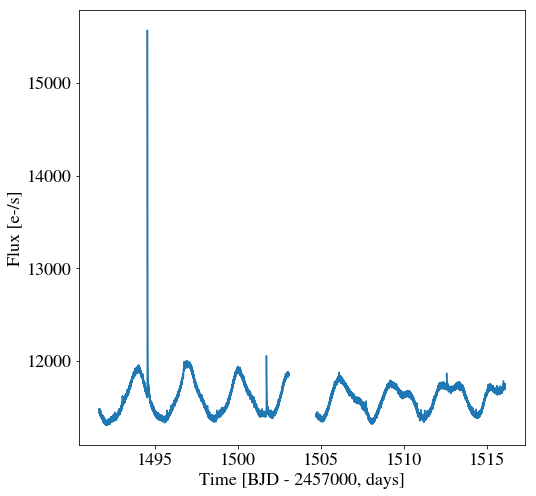

In [157]:
with fits.open(path+f1, mode='readonly') as hdulist:
    tess_bjds = hdulist[1].data['TIME']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_flux_error = hdulist[1].data['PDCSAP_FLUX_ERR']
    tess_quality = hdulist[1].data['QUALITY']

fig, axes = plt.subplots(figsize=(8,8))
axes.plot(tess_bjds, pdcsap_fluxes)
axes.set_xlabel('Time [BJD - 2457000, days]')
axes.set_ylabel('Flux [e-/s]')

In [158]:
# Throw out NaN fluxes
mask = ~np.isnan(pdcsap_fluxes)
time = tess_bjds[mask]
flux = pdcsap_fluxes[mask]
quality = tess_quality[mask]
median = np.median(flux)
error = pdcsap_flux_error[mask]

#### Change Point Analysis <a class="anchor" id="cpa"></a>

In [159]:
# Identify flares using change point analysis function
istart_i, istop_i = FINDflare(flux, error)

(1494.3, 1494.75)

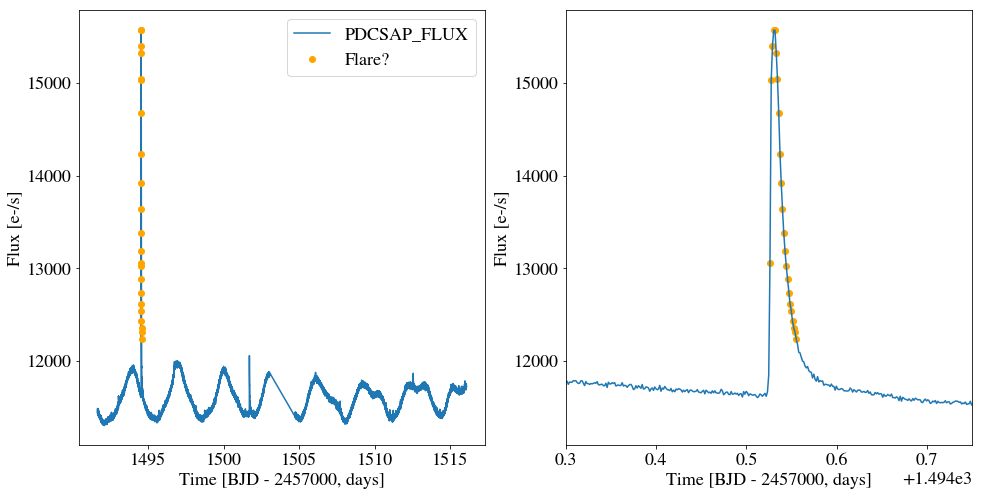

In [160]:
fig, axes = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
axes[0].plot(time, flux, label='PDCSAP_FLUX')
axes[0].set_xlabel('Time [BJD - 2457000, days]')
axes[0].set_ylabel('Flux [e-/s]')

for idx in range(len((istart_i))):
    l = 'Flare?' if idx == 0 else '_nolabel_'
    axes[0].plot(time[istart_i[idx]:istop_i[idx]], flux[istart_i[idx]:istop_i[idx]], 'o', color='orange', label=l)
    axes[1].plot(time[istart_i[idx]:istop_i[idx]], flux[istart_i[idx]:istop_i[idx]], 'o', color='orange', label=l) 

axes[0].legend()

axes[1].plot(time, flux, label='PDCSAP_FLUX')
axes[1].set_xlabel('Time [BJD - 2457000, days]')
axes[1].set_ylabel('Flux [e-/s]')
axes[1].set_xlim(1494.3, 1494.75)

#### Change Point Analysis + Rolling Median Subtraction <a class="anchor" id="cpaminroll"></a>

Text(0, 0.5, 'Flux [e-/s]')

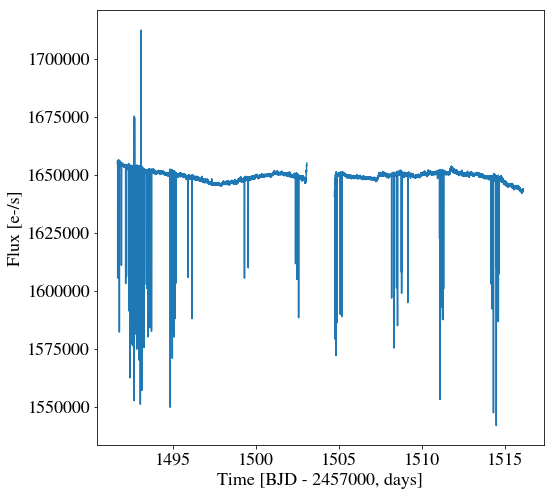

In [209]:
with fits.open(path+f4, mode='readonly') as hdulist:
    tess_bjds = hdulist[1].data['TIME']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_flux_error = hdulist[1].data['PDCSAP_FLUX_ERR']
    tess_quality = hdulist[1].data['QUALITY']

fig, axes = plt.subplots(figsize=(8,8))
axes.plot(tess_bjds, pdcsap_fluxes)
axes.set_xlabel('Time [BJD - 2457000, days]')
axes.set_ylabel('Flux [e-/s]')

In [210]:
# Throw out NaN fluxes
mask = ~np.isnan(pdcsap_fluxes)
time = tess_bjds[mask]
flux = pdcsap_fluxes[mask]
quality = tess_quality[mask]
median = np.median(flux)
error = pdcsap_flux_error[mask]

In [211]:
ok_cut = quality == 0

median = np.nanmedian(flux[ok_cut])
acf = xo.autocorr_estimator(time[ok_cut], flux[ok_cut]/median,
                            yerr=error[ok_cut]/median,
                            min_period=0.1, max_period=27, max_peaks=2)

if len(acf['peaks']) > 0:
    acf_1dt = acf['peaks'][0]['period']
    mask = np.where((acf['autocorr'][0] == acf['peaks'][0]['period']))[0]
    acf_1pk = acf['autocorr'][1][mask][0]
    s_window = int(acf_1dt/np.fabs(np.nanmedian(np.diff(time))) / 6)
else:
    s_window = 128
    
smo = pd.DataFrame(flux[ok_cut]).rolling(s_window, center=True).median().values
smo = smo.reshape(1, -1)[0]

sok_cut = np.isfinite(smo)

istart_i, istop_i = FINDflare((flux[ok_cut][sok_cut]-smo[sok_cut])/median, 
                              error[ok_cut][sok_cut]/median, avg_std=False, N1=4, N2=2, N3=5)

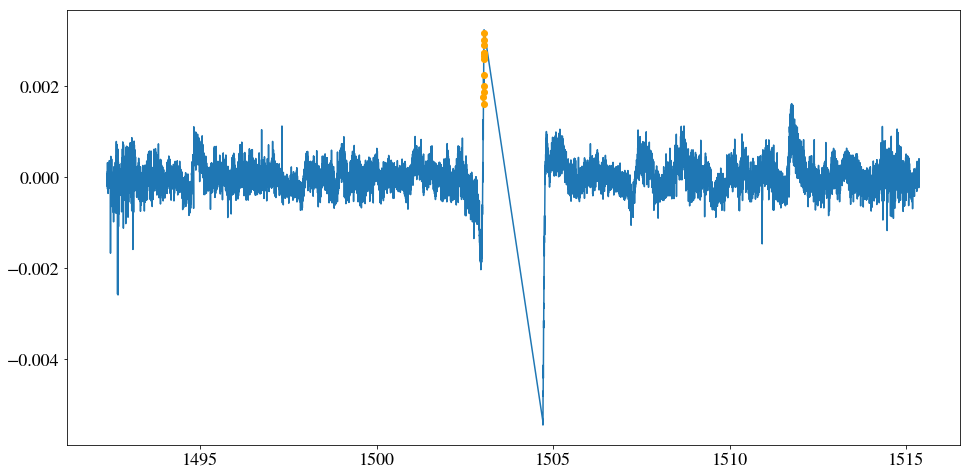

In [212]:
fig, axes = plt.subplots(figsize=(16,8))
axes.plot(time[ok_cut][sok_cut], (flux[ok_cut][sok_cut]-smo[sok_cut])/median)

ymin, ymax = axes.get_ylim()
for idx in range(len((istart_i))):
    l = 'Flare?' if idx == 0 else '_nolabel_'
    axes.plot(time[ok_cut][sok_cut][istart_i[idx]:istop_i[idx]], 
              (flux[ok_cut][sok_cut][istart_i[idx]:istop_i[idx]]-smo[sok_cut][istart_i[idx]:istop_i[idx]])/median,
              'o', color='orange', label=l)

Looks like the strange flare detection has to do with a huge change in the rolling standard deviation.

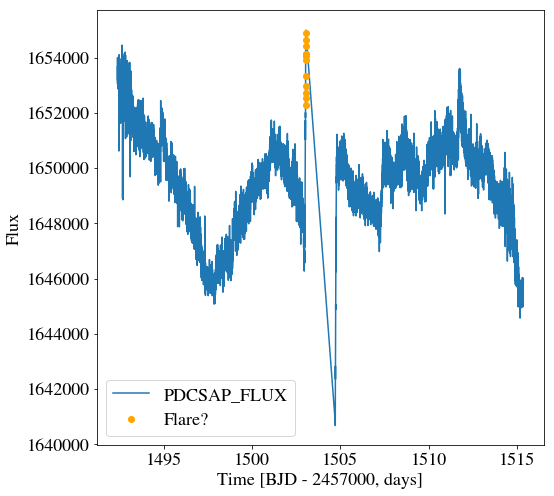

In [101]:
fig, axes = plt.subplots(figsize=(8,8))
axes.plot(time[ok_cut][sok_cut], flux[ok_cut][sok_cut], label='PDCSAP_FLUX')
axes.set_xlabel('Time [BJD - 2457000, days]')
axes.set_ylabel('Flux')

for idx in range(len((istart_i))):
    l = 'Flare?' if idx == 0 else '_nolabel_'
    axes.plot(time[ok_cut][sok_cut][istart_i[idx]:istop_i[idx]], 
              flux[ok_cut][sok_cut][istart_i[idx]:istop_i[idx]], 'o', color='orange', label=l)
    
axes.legend()

It looks like we are running into problems when the rolling std crosses the gap in the data. What if we split the light curve into two segments and work on each segment separately?

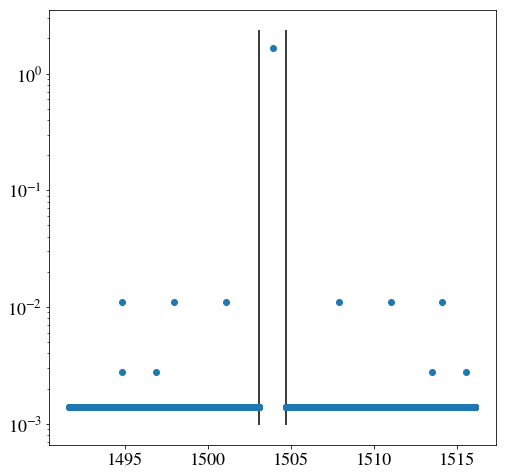

In [102]:
fig, axes = plt.subplots(figsize=(8,8))
t_mid = 0.5*(time[1:] + time[:-1])
t_diff = np.diff(time)
axes.semilogy(t_mid, t_diff, 'o')

# Index of the beginning and end of the big gap
i_start, i_end = np.argmax(t_diff) - 1, np.argmax(t_diff) + 1
t_start, t_end = time[i_start], time[i_end]
ymin, ymax = axes.get_ylim()
axes.vlines([t_start, t_end], ymin, ymax)

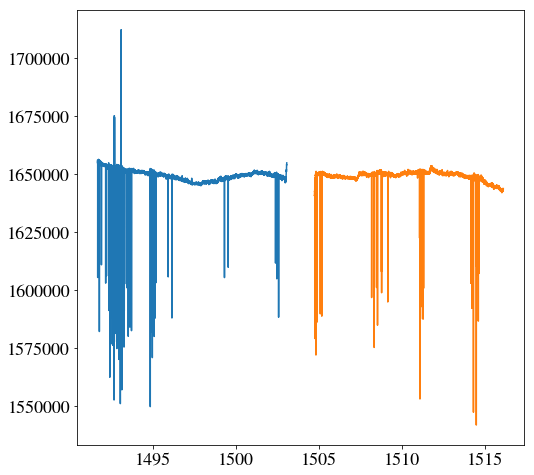

In [103]:
time1 = time[time <= t_start]
time2 = time[time >= t_end]
flux1 = flux[time <= t_start]
flux2 = flux[time >= t_end]
error1 = error[time <= t_start]
error2 = error[time >= t_end]
quality1 = quality[time <= t_start]
quality2 = quality[time >= t_end]

fig, axes = plt.subplots(figsize=(8,8))
axes.plot(time1, flux1)
axes.plot(time2, flux2)

In [104]:
ok_cut = quality1 == 0

median = np.nanmedian(flux1[ok_cut])
acf = xo.autocorr_estimator(time1[ok_cut], flux1[ok_cut]/median,
                            yerr=error1[ok_cut]/median,
                            min_period=0.1, max_period=27, max_peaks=2)

if len(acf['peaks']) > 0:
    acf_1dt = acf['peaks'][0]['period']
    mask = np.where((acf['autocorr'][0] == acf['peaks'][0]['period']))[0]
    acf_1pk = acf['autocorr'][1][mask][0]
    s_window = int(acf_1dt/np.fabs(np.nanmedian(np.diff(time1))) / 6)
else:
    s_window = 128
    
smo = pd.DataFrame(flux1[ok_cut]).rolling(s_window, center=True).median().values
smo = smo.reshape(1, -1)[0]

smo_std = pd.DataFrame(flux1[ok_cut]/median).rolling(s_window, center=True).std().values
smo_std = smo_std.reshape(1, -1)[0]
smo_std1 = pd.DataFrame((flux1[ok_cut]-smo)/median).rolling(s_window, center=True).std().values
smo_std1 = smo_std1.reshape(1, -1)[0]

sok_cut = np.isfinite(smo)

istart_i, istop_i = FINDflare((flux1[ok_cut][sok_cut]-smo[sok_cut])/median, 
                              error1[ok_cut][sok_cut]/median, avg_std=False, N1=4, N2=2, N3=5)

print(str(len(istart_i)) + ' flares found')

0 flares found


Looks like it worked!

#### CPA With Iterative Rolling Median Subtraction <a class="anchor" id="cpaminrollit"></a>

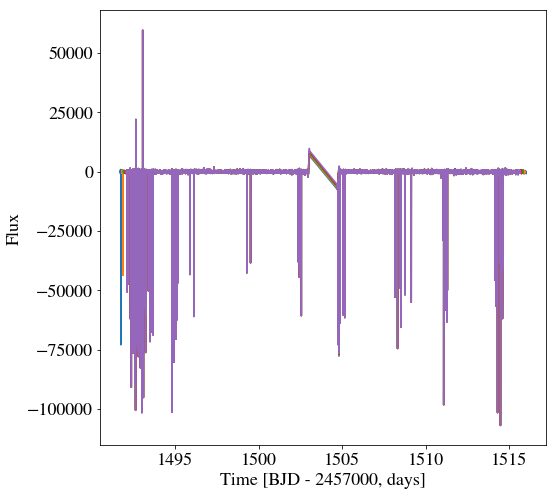

In [105]:
fig, axes = plt.subplots(figsize=(8,8))

flux_red = np.copy(flux)
for k in range(5):
    smo = pd.DataFrame(flux_red).rolling(128, center=True).median().values
    smo = smo.reshape(1, -1)[0]
    
    flux_red = flux_red - smo
    
    axes.plot(time, flux_red, label='PDCSAP_FLUX')
    axes.set_xlabel('Time [BJD - 2457000, days]')
    axes.set_ylabel('Flux')
    
istart_i, istop_i = FINDflare(flux_red/median, error/median, avg_std=False, N1=4, N2=2, N3=5)
for idx in range(len((istart_i))):
    l = 'Flare?' if idx == 0 else '_nolabel_'
    axes.plot(time[istart_i[idx]:istop_i[idx]], flux_red[istart_i[idx]:istop_i[idx]], 'o',
              color='orange', label=l)

#### Change Point Analysis Plus Iterative Least Squares Spline Fit Subtraction <a class="anchor" id="cpaminspline"></a>

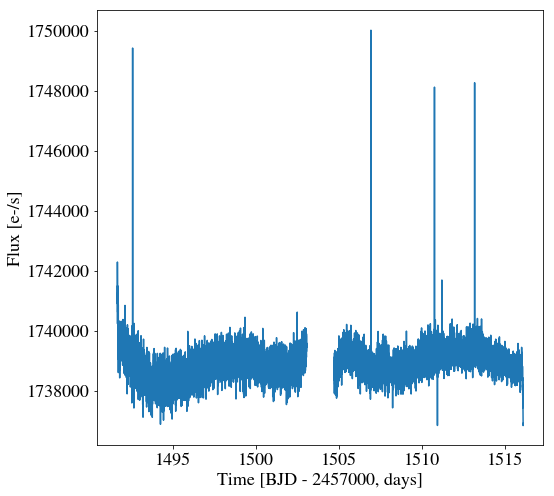

In [202]:
with fits.open(path+f5, mode='readonly') as hdulist:
    tess_bjds = hdulist[1].data['TIME']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_flux_error = hdulist[1].data['PDCSAP_FLUX_ERR']
    tess_quality = hdulist[1].data['QUALITY']

fig, axes = plt.subplots(figsize=(8,8))
axes.plot(tess_bjds, pdcsap_fluxes)
axes.set_xlabel('Time [BJD - 2457000, days]')
axes.set_ylabel('Flux [e-/s]')

# Throw out NaN fluxes and do a quality cut
mask = ~np.isnan(pdcsap_fluxes)
time = tess_bjds[mask]
flux = pdcsap_fluxes[mask]
quality = tess_quality[mask]
median = np.median(flux)
error = pdcsap_flux_error[mask]

In [203]:
ok_cut = quality == 0
median = np.nanmedian(flux[ok_cut])

smo = IRLSSpline(time[ok_cut], flux[ok_cut]/median, error[ok_cut]/median)

sok_cut = np.isfinite(smo)

istart_i, istop_i = FINDflare((flux[ok_cut][sok_cut]-smo[sok_cut])/median, error[ok_cut][sok_cut]/median,
                               avg_std=False, N1=4, N2=2, N3=5)

print(str(len(istart_i)) + ' flares found')

1 flares found


(1491.6, 1491.8)

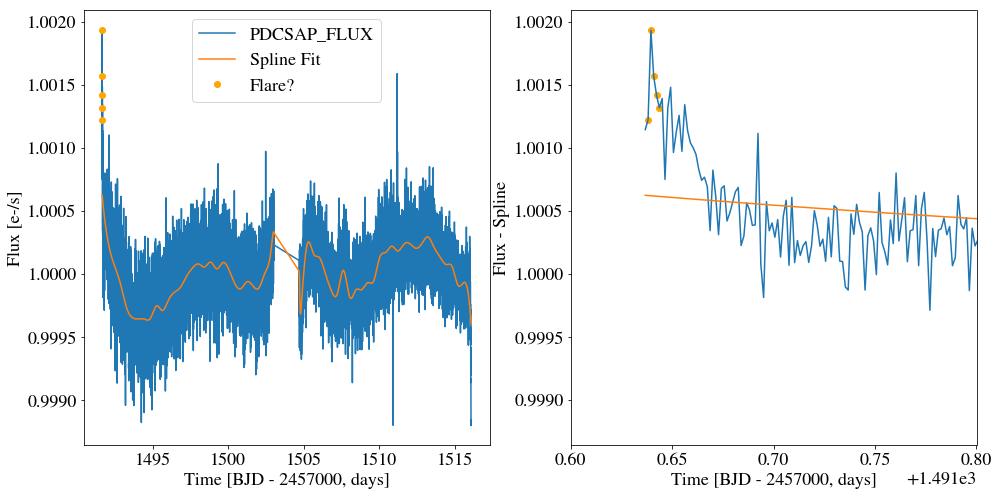

In [204]:
fig, axes = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
axes[0].plot(time[ok_cut][sok_cut], flux[ok_cut][sok_cut]/median, label='PDCSAP_FLUX')
axes[0].plot(time[ok_cut][sok_cut], smo[sok_cut], label='Spline Fit')
axes[0].set_xlabel('Time [BJD - 2457000, days]')
axes[0].set_ylabel('Flux [e-/s]')

for idx in range(len((istart_i))):
    l = 'Flare?' if idx == 0 else '_nolabel_'
    axes[0].plot(time[ok_cut][sok_cut][istart_i[idx]:istop_i[idx]], flux[ok_cut][sok_cut][istart_i[idx]:istop_i[idx]]/median,
                 'o', color='orange', label=l)
    axes[1].plot(time[ok_cut][sok_cut][istart_i[idx]:istop_i[idx]], flux[ok_cut][sok_cut][istart_i[idx]:istop_i[idx]]/median,
                 'o', color='orange', label=l)

axes[0].legend()

axes[1].plot(time[ok_cut][sok_cut], (flux[ok_cut][sok_cut]-smo[sok_cut])/median)
axes[1].plot(time[ok_cut][sok_cut], smo[sok_cut])
axes[1].set_xlabel('Time [BJD - 2457000, days]')
axes[1].set_ylabel('Flux - Spline')
axes[1].set_xlim(1491.6, 1491.8)

Why is a flare being detected at the beginning of the light curve? This seems to be happening for a bunch of sources and only when I do the iterative spline fitting.<br>

Looks like the spline model doesn't fit well at the beginning of the light curve.

#### CPA Plus Gaussian Process Subtraction <a class="anchor" id="cpagausssub"></a>

See <a href="https://ui.adsabs.harvard.edu/abs/2018MNRAS.474.2094A">Angus 2017</a> for a discussion of using gaussian processes to model stellar rotation

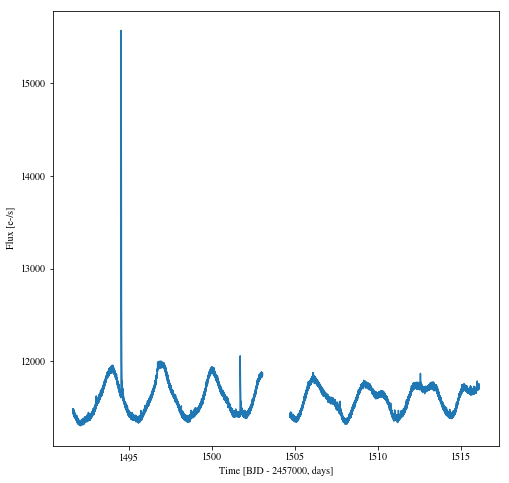

In [16]:
with fits.open(path+f1, mode='readonly') as hdulist:
    tess_bjds = hdulist[1].data['TIME']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_flux_error = hdulist[1].data['PDCSAP_FLUX_ERR']
    tess_quality = hdulist[1].data['QUALITY']

fig, axes = plt.subplots(figsize=(8,8))
axes.plot(tess_bjds, pdcsap_fluxes)
axes.set_xlabel('Time [BJD - 2457000, days]')
axes.set_ylabel('Flux [e-/s]')

# Throw out NaN fluxes
mask = ~np.isnan(pdcsap_fluxes)
time = tess_bjds[mask]
flux = pdcsap_fluxes[mask]
quality = tess_quality[mask]
median = np.median(flux)
error = pdcsap_flux_error[mask]

3.1267200400300226


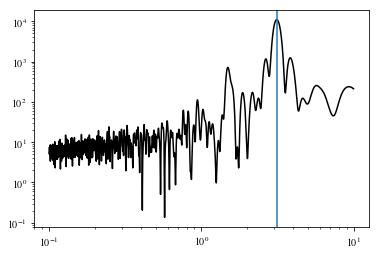

In [17]:
from astropy.stats import LombScargle

# First guess at the period
freq = np.linspace(0.1, 10.0, 5000)
model = LombScargle(time, flux)
power = model.power(freq, method="fast", normalization="psd")
power /= len(time)

period = 1.0 / freq[np.argmax(power)]
print(period)

plt.plot(1.0 / freq, power, "k")
plt.axvline(period)
plt.xscale("log")
plt.yscale("log")

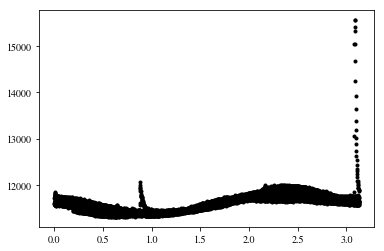

In [18]:
plt.plot(time % period, flux, '.k')

In [19]:
import exoplanet as xo

median = np.nanmedian(flux)

acf = xo.autocorr_estimator(time, flux/median,
                            yerr=error/median,
                            min_period=0.1, max_period=27, max_peaks=2)

print(acf['peaks'][0]['period'])

3.097860324523708


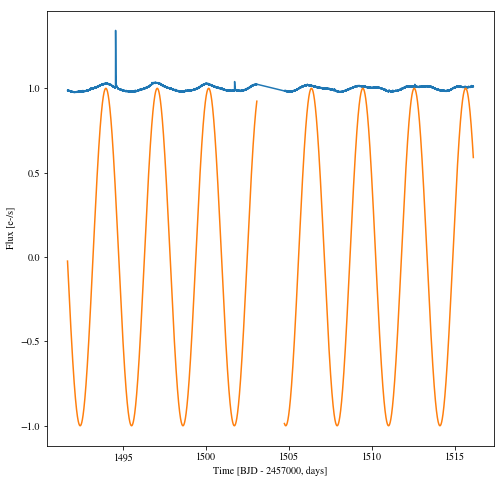

In [20]:
fig, axes = plt.subplots(figsize=(8,8))
axes.plot(time, flux/median)
axes.set_xlabel('Time [BJD - 2457000, days]')
axes.set_ylabel('Flux [e-/s]')

T = acf['peaks'][0]['period']
y_model = np.sin(2*np.pi/T*tess_bjds)
axes.plot(tess_bjds, y_model)

In [21]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    # The mean flux of the time series
    mean = pm.Normal('mean', mu=1.0, sd=10.0)
    
    # A jitter term describing excess white noise
    logs2 = pm.Normal('logs2', mu=2*np.log(np.min(error)), sd=5.0)
    
    # The parameters of the RotationTerm kernel
    logamp = pm.Normal('logamp', mu=np.log(np.var(flux)), sd=5.0)
    logperiod = pm.Normal('logperiod', mu=np.log(T), sd=5.0)
    logQ0 = pm.Normal('logQ0', mu=1.0, sd=10.0)
    logdeltaQ = pm.Normal('logdeltaQ', mu=2.0, sd=10.0)
    mix = pm.Uniform('mix', lower=0, upper=1.0)
    
    # Track the period as a deterministic
    period = pm.Deterministic('period', tt.exp(logperiod))
    # Set up the Gaussian Process model
    kernel = xo.gp.terms.RotationTerm(
        log_amp=logamp,
        period=period,
        log_Q0=logQ0,
        log_deltaQ=logdeltaQ,
        mix=mix
    )

    x = np.ascontiguousarray(time, dtype=np.float64)
    y = np.ascontiguousarray(flux, dtype=np.float64)/median
    yerr = np.ascontiguousarray(error, dtype=np.float64)/median
    gp = xo.gp.GP(kernel, x, yerr**2 + tt.exp(logs2), J=4)

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    pm.Potential('loglike', gp.log_likelihood(y - mean))

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic('pred', gp.predict())

    # Optimize to find the maximum a posteriori parameters
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp', 'logs2', 'mean']
message: Desired error not necessarily achieved due to precision loss.
logp: -66327.93361654552 -> nan


Text(0, 0.5, 'Flux [e-/s]')

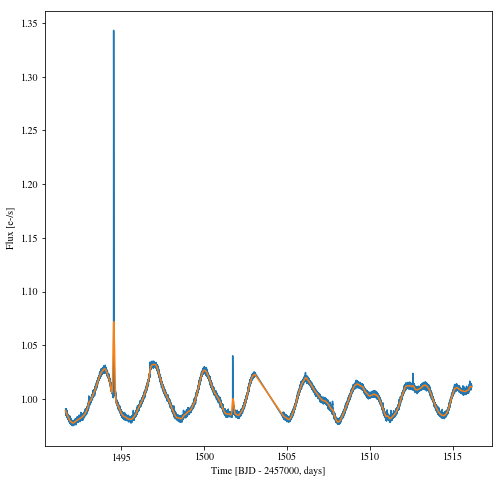

In [22]:
fig, axes = plt.subplots(figsize=(8,8))
gpspl = map_soln['pred']
axes.plot(time, flux/median, label='PDCSAP_FLUX')
axes.plot(time, gpspl+1, label='GP')
axes.set_xlabel('Time [BJD - 2457000, days]')
axes.set_ylabel('Flux [e-/s]')